# Projekt Zespołowy - Zastosowanie oraz porównanie istniejących architektur do klasyfikacji obrazów na przykładzie CIFAR-10

## Wstęp

### Cel

Celem projektu jest omówienie oraz porównanie wybranych modeli uczenia maszynowego do klasyfiakcji obrazów na przykładzie zbioru CIFAR-10.

### Dataset

CiFar-10 to zbiór danych, który składa się z 60000 kolorowych obrazów o rozmiarze 32x32 pikseli, podzielonych na 10 klas. Każda klasa zawiera 6000 obrazów. Zbiór ten zawiera 50000 obrazów treningowych oraz 10000 obrazów testowych.

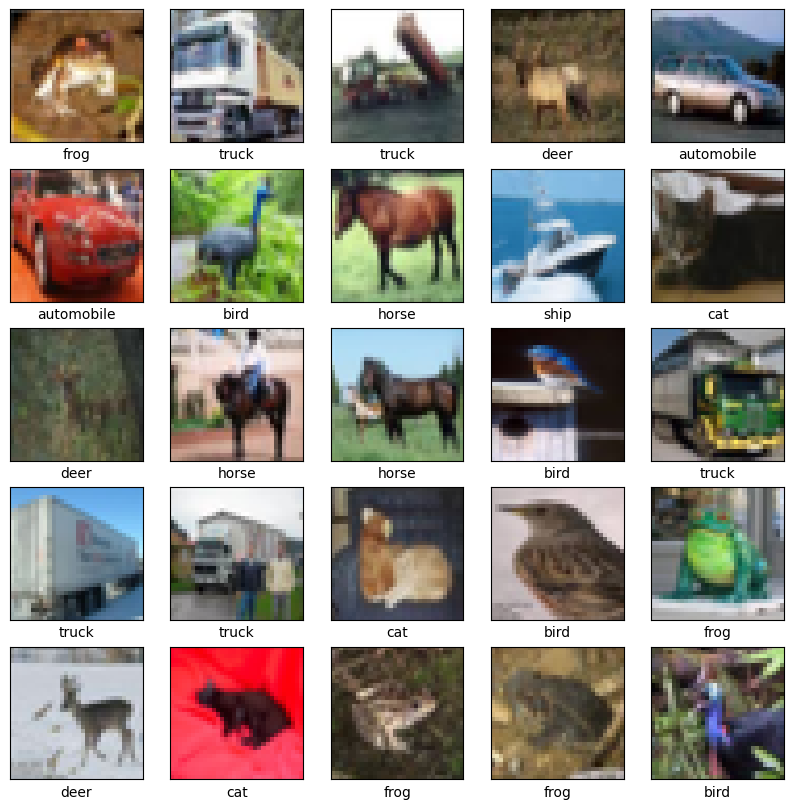

In [88]:

# Import oraz demonstracja danych
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Etkiety klas
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Wyświetlenie przykładowych obrazów
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


Wszystkich klas jest po równo, co oznacza, że zbiór jest zbalansowany:

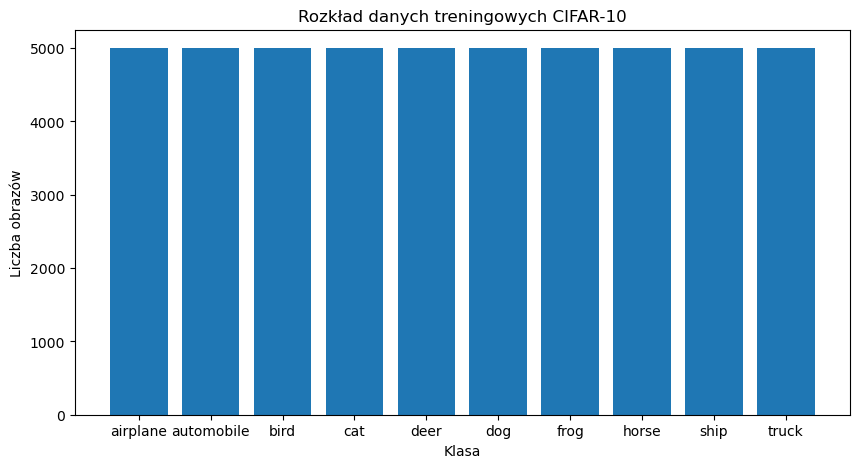

In [3]:
# Analiza rozkładu danych treningowych
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Wyświetlenie rozkładu klas
plt.figure(figsize=(10, 5))
plt.bar(class_names, counts)
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład danych treningowych CIFAR-10')
plt.show()


### Wyniki modeli SOTA w porównaniu z ludźmi

![Przykładowe wyniki](images/przykladowe_wyniki.png)

<font size="3"><i>Ho-Phuoc, T. (Year). CIFAR10 to Compare Visual Recognition Performance between Deep Neural Networks and Humans. The University of Danang – University of Science and Technology.<font><i>

Jak widać, modele widzenia komputerowego "State Of The Art" oparte na sieciach neuronowych od kilku lat osigają wyniki przewyższające ludzkie.

## Uczenie płytkie

### Regresja logistyczna 

Regresja logistyczna jest w pewnym sensie rozszerzeniem regresji liniowej. Podobnie jak w regresji liniowej, obliczamy ważoną sumę cech wejściowyc, lecz dodatkowo przekształcamy wynik za pomocą funkcji logistycznej (odpowiednik prawdopodobieństwa), która zwraca wartości z przedziału [0, 1]:

![Regresja logistyczna 1](images/logreg1.png)

![Regresja logistyczna 2](images/logreg2.png)

<font size="3"><i>Obrazki pochodzą z książki _"Uczenie maszynowe z wykorzystaniem Scikit-Learn, Keras i TensorFlow"_ autorstwa Aurélien Géron.</i></font>

Tym razem funkcję kosztu definiujemy w ten sposób, żeby model zwracał prawdopodobieństwa bliskie 1 dla obserwacji z klasy 1 oraz bliskie 0 dla obserwacji z klasy 0:

![Regresja logistyczna 3](images/logreg3.png)

![Regresja logistyczna 4](images/logreg4.png)

Niestety w odróżnieniu od regresji liniowej nie ma rozwiązania analitycznego, więc musimy posłużyć się metodami optymalizacji numerycznej, np. metodą gradientową. Dobrą wiadomością jest to, że funkcja kosztu jest wypukła, więc nie ma problemu z lokalnymi minimami.

Żeby użyć regresji logistycznej do klasyfikacji wieloklasowej, możemy posłużyć się metodą One-vs-All, czyli trenujemy tyle modeli binarnych, ile mamy klas (każdy model będzie szacował prowdopodobieństwo prznależności do pojedyńczej klasy), a następnie wybieramy klasę z najwyższym prawdopodobieństwem.

Jeszcze lepszym rozwiązaniem jest użycie metody Softmax, która pozwala na oszacowanie prawdopodobieństwa przynależności do każdej z klas jednocześnie. W tym przypadku przypisujemy każdej klasie swój wektor wag, a wynik przekształcamy za pomocą funkcji softmax ($\hat{p}_k$
to prawdopodobieństwo przynależności próbki do klasy k):

![Regresja logistyczna 5](images/logreg5.png)

Po zastosowaniu tak wybranego klasyfikatora, otrzymujemy następującą funkcję kosztu (inaczej entropia krzyżowa):

![Regresja logistyczna 6](images/logreg6.png)

Użyjemy regresji logistycznej Softmax do klasyfikacji obrazów z CIFAR-10. W tym celu najpierw przeskalujemy dane, a następnie podzielimy zbiór danych na zbiór treningowy i testowy. Potem zdefiniujemy model regresji logistycznej, skompilujemy go oraz wytrenujemy. Na końcu ocenimy jakość modelu.

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

# Załaduj dane CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Przeskaluj dane
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encoding etykiet
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Zdefiniuj model regresji logistycznej Softmax
model = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(10, activation='softmax')
])

# Skompiluj model
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

# Wytrenuj model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Oceń model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


Epoch 1/10
1250/1250 [==============================] - 2s 1ms/step - loss: 1.9591 - accuracy: 0.2991 - val_loss: 1.9434 - val_accuracy: 0.3069
Epoch 2/10
1250/1250 [==============================] - 2s 1ms/step - loss: 1.8518 - accuracy: 0.3483 - val_loss: 1.8605 - val_accuracy: 0.3562
Epoch 3/10
1250/1250 [==============================] - 2s 1ms/step - loss: 1.8172 - accuracy: 0.3641 - val_loss: 1.8026 - val_accuracy: 0.3780
Epoch 4/10
1250/1250 [==============================] - 2s 1ms/step - loss: 1.7980 - accuracy: 0.3727 - val_loss: 1.8519 - val_accuracy: 0.3593
Epoch 5/10
1250/1250 [==============================] - 1s 1ms/step - loss: 1.7866 - accuracy: 0.3746 - val_loss: 1.8484 - val_accuracy: 0.3583
Epoch 6/10
1250/1250 [==============================] - 2s 1ms/step - loss: 1.7735 - accuracy: 0.3824 - val_loss: 1.8492 - val_accuracy: 0.3460
Epoch 7/10
1250/1250 [==============================] - 2s 1ms/step - loss: 1.7637 - accuracy: 0.3896 - val_loss: 1.9236 - val_accuracy:

Natychmiast udało się osiągnąć prawie 40% dokładności. Spróbujemy jeszcze polepszyć wynik za pomocą regularyzacji oraz optymalizacji hiperparametrów. Regularyzacja polega na dodaniu do funkcji kosztu kary za duże wagi, co pozwala na uniknięcie overfittingu. Optymalizacja hiperparametrów polega na znalezieniu takich wartości hiperparametrów (np. learning rate, batch size, liczba epok), które pozwolą na uzyskanie najlepszego wyniku.

Teraz wykorzystamy do zdefiniowania modelu bibliotekę PyTorch, ponieważ dużo szybciej będzie uruchamiać się na GPU (TensorFlow słabo obsługuje GPU na Windows).

In [10]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from accelerate import Accelerator
from sklearn.model_selection import ParameterGrid

torch.cuda.empty_cache()  # Clear GPU cache

# Initialize the accelerator
accelerator = Accelerator()

# Enable benchmark mode in cuDNN for optimal performance
torch.backends.cudnn.benchmark = True

# Define transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Prepare CIFAR-10 dataset
train_dataset = datasets.CIFAR10(os.getcwd(), train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(os.getcwd(), train=False, download=True, transform=transform)

# Function to create DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, persistent_workers=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, persistent_workers=False)
    return train_loader, test_loader

# Define the Softmax Regression model
class SoftmaxRegression(nn.Module):
    def __init__(self):
        super(SoftmaxRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*32*3, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs, param_set):
    model.train()
    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        print(f'[{param_set}] Epoch [{epoch + 1}/{epochs}] Loss: {current_loss / len(train_loader):.4f}')
    torch.cuda.empty_cache()  # Clear GPU cache

# Function to test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Hyperparameters for optimization
param_grid = {
    'batch_size': [32, 512],
    'epochs': [10, 20],
    'learning_rate': [0.001, 0.01, 0.1],
    'l2_regularization': [0.001, 0.01, 0.1]
}

# Optimize hyperparameters
best_acc = 0
best_params = None

for params in ParameterGrid(param_grid):
    param_set = f"batch_size={params['batch_size']}, epochs={params['epochs']}, lr={params['learning_rate']}, l2={params['l2_regularization']}"
    print(f"Training with parameters: {param_set}")
    
    train_loader, test_loader = create_dataloader(params['batch_size'])
    
    model = SoftmaxRegression()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['l2_regularization'])
    
    # Prepare with accelerator
    model, optimizer, train_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, test_loader)
    
    train_model(model, train_loader, criterion, optimizer, params['epochs'], param_set)
    acc = test_model(model, test_loader)
    
    if acc > best_acc:
        best_acc = acc
        best_params = params

    # Clean up DataLoader to free up memory
    del train_loader
    del test_loader
    torch.cuda.empty_cache()  # Clear GPU cache

print(f'Best accuracy: {best_acc}')
print(f'Best parameters: {best_params}')


Files already downloaded and verified
Files already downloaded and verified
Training with parameters: batch_size=32, epochs=10, lr=0.001, l2=0.001
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [1/10] Loss: 1.9061
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [2/10] Loss: 1.8467
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [3/10] Loss: 1.8243
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [4/10] Loss: 1.8152
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [5/10] Loss: 1.8088
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [6/10] Loss: 1.8064
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [7/10] Loss: 1.7979
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [8/10] Loss: 1.7944
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [9/10] Loss: 1.7973
[batch_size=32, epochs=10, lr=0.001, l2=0.001] Epoch [10/10] Loss: 1.7889
Training with parameters: batch_size=32, epochs=10, lr=0.01, l2=0.001
[batch_size=32, epochs=10, lr=0.01, l2=0.001] Epoch 

Jak się okazało, najlepsze parametry to: batch_size=512, epochs=20, lr=0.001, l2=0.001, lecz dokładność modelu pozostała na bardzo zbliżonym poziomie. Jak widać regresja nie pasuje do tego problemu, ponieważ nie jest w stanie wyodrębnić cech obrazów. Spróbujemy teraz zastosować inne modele.

### Drzewa decyzyjne

Drzewo decyzyjne to algorytm uczenia maszynowego oparty o uczenie nadzorowane. Może być używane do regresji, chociaż częściej jest używane do klasyfikacji. Drzewo decyzyjne posiada hierarchiczną strukturę drzewiastą.

![drzewo decyzyjne](images/decision.png)

Każde drzewo składa się z korzenia, gałęzi, węzłów decyzyjnych oraz liści.

#### Algorytm budowy (trenowania) drzewa decyzyjnego
Zakładamy, że mamy pary $(x_i, y_i)$ gdzie $x \in R^d$ należy do przestrzeni cech (atrybutów) oraz $y_i$ jest etykietą klasy.
1. Wybierz atrybut, który najlepiej dzieli dane. Przy wybieraniu atrybutu można się posłużyć wieloma miarami. Kilka z nich to:<br><br>
    1. <b>Zysk informacji:</b> Mierzy zmniejszenie entropii po podziale danych według danego atrybutu.
        &emsp;$IG(S,A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|}H(S_v)$ <br>
        &emsp;gdzie: <br>
            &emsp;&emsp;$H(S)$ - entropia na zbiorze S <br>
            &emsp;&emsp;$S_v$ - podzbiór danych w którym atrybut A ma wartość v <br><br>
    2. <b>Indeks Giniego:</b> Mierzy czystość zbioru danych po podziale według danego atrybutu. <br>
        &emsp;$Gini(S,A) = \sum_{v \in Values(A)} \frac{|S_v|}{|S|}Gini(S_v)$
        &emsp;gdzie: <br>
        &emsp;&emsp;$S_v$ - podzbiór danych w którym atrybut A ma wartość v <br><br>
dla każdego atrybutu obliczamy daną metrykę po podziale da


Drzewo decyzyjne może być binarne lub posiadać większą ilość gałęzi. Drzewo może mieć ograniczoną głębokość lub może być dzielone aż do momentu idealnej czystości węzła (wszystkie elementy należą do tej samej klasy) albo nie ma więcej atrybutów do podziału

### Lasy losowe

### Maszyny Wektorów Nośnych

### Algorytm KNN

KNN to prosty algorytm uczenia maszynowego wykorzystywany głównie do klasyfikacji, chociaż może być wykorzystany również do regresji. Główną ideę algorytmu można opisać następująco: dla danej próby znajdź k najbliższych elementów w zbiorze treningowym wykorzystując podaną metrykę. Klasa, która jest najbardziej liczna w wybranym podzbiorze jest wynikiem klasyfikacji.

#### Kroki algorytmu
1. Zdefiniuj przestrzeń cech $R^{d}$, etykiety klas $Y=\{y_1, y_2, ..., y_n\}$ oraz parametr $k \in \mathbb{N}$.
2. Podaj zbiór par cecha-etykieta $(X_i,y_i)$.
3. Wybierz normę $||\cdot||$ na $R^{d}$ .
4. Wtedy funkcja $f: R^{d} \mapsto Y$, $ f(x) =  mode(\{y_i: i \leq k\})$ gdzie dla $x \in R^d$ oznaczamy $(X_1, y_1), (X_2, y_2) ... (X_n, y_n)$ tak że $||X_1 - x|| \leq ... \leq ||X_n - x||$ oraz $mode()$ oznacza wybranie elementu najczęściej powtarzającego się.
5. Wtedy predykcja dla $x$ to $f(x)$.

![knn2](images/knn2.png)

Algorytm KNN zakłada, że dane znajdujące się w tej samej klasie mają podobne cechy do siebie nawzajem podczas gdy dane z różnych klas mają cechy znacznie różniące się od siebie.

In [79]:
class kNearestNeighbour(object):
    def __init__(self):
        ...
    
    def train(self,X,Y):
        #Zapamiętaj dane uczące
        self.X_train = X
        self.Y_train = Y
        
    def predict(self,X,k):
        #ilość prób
        test_samples = X.shape[0]
        
        Ypred = np.zeros(test_samples, dtype=self.Y_train.dtype)
        
        #Oblicz dystans l1 pomiędzy danymi trenowanymi a próbką
        for i in range(test_samples):
            
            #zlicz etykiety klas
            label_count = np.zeros(10, dtype=self.Y_train.dtype)    
            
            dist = np.sqrt(np.sum((self.X_train - X[i, :])**2, axis=1))
            
            idx = np.argpartition(dist, k)
            min_ind = idx[:k]
            for x in min_ind:
                label_count[int(self.Y_train[x])] +=1
            Ypred[i] = np.argmax(label_count)
    
    
        return Ypred

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

sample_size = 10000

knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn_classifier.fit(x_train.reshape(x_train.shape[0], -1), y_train.flatten())

# Make predictions on the test set
y_pred = knn_classifier.predict(x_test.reshape(x_test.shape[0], -1)[0:sample_size])

# Calculate accuracy
accuracy = accuracy_score(y_test.flatten()[0:sample_size], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3398


Aby polepszyć wyniki możemy przeskalować wymiary cech tak aby odległość w każdym wymiarze miała równy wpływ na wynik klasyfikacji niezależnie od wariancji danych w tym wymiarze.

In [120]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

knn_classifier = KNeighborsClassifier(n_neighbors=5)
scaler = StandardScaler()

knn_classifier_scaled = Pipeline([
    ('scaler', scaler),  # Add scaler step
    ('classifier', knn_classifier)  # Add classifier step
])

# Train the classifier
knn_classifier_scaled.fit(x_train.reshape(x_train.shape[0], -1), y_train.flatten())

# Make predictions on the test set
y_pred = knn_classifier_scaled.predict(x_test.reshape(x_test.shape[0], -1)[0:sample_size])

# Calculate accuracy
accuracy = accuracy_score(y_test.flatten()[0:sample_size], y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3417


Osiągneliśmy troszkę lepszy wynik

#### krzywa ROC
Możemy obliczyć wynik ROC oraz AUC.

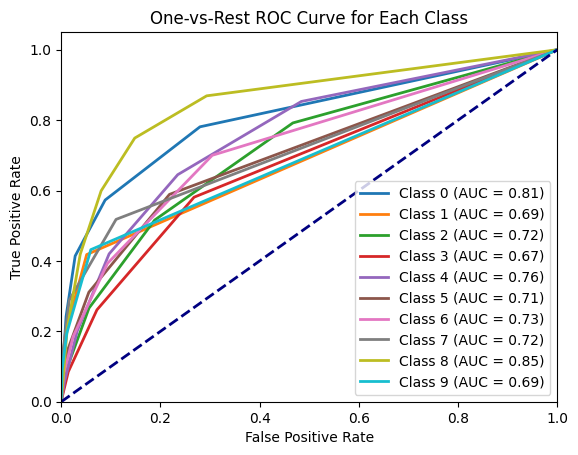

In [121]:
from sklearn.metrics import roc_curve, auc

plt.figure()
x_test_sample, y_test_sample = x_test.reshape(x_test.shape[0], -1)[0:sample_size], y_test.flatten()[0:sample_size]
# Iterate over each class
for i in range(10):  # Assuming 10 classes
    # Convert multiclass labels to binary labels for the selected class
    y_binary = np.array([1 if label == i else 0 for label in y_test_sample])
    
    # Predict probabilities for the selected class
    y_scores = knn_classifier_scaled.predict_proba(x_test_sample)[:, i]  # Probability for class i
    
    # Compute ROC curve and AUC for the selected class
    fpr, tpr, thresholds = roc_curve(y_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the selected class
    plt.plot(fpr, tpr, lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc))

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

#### Krzywa uczenia


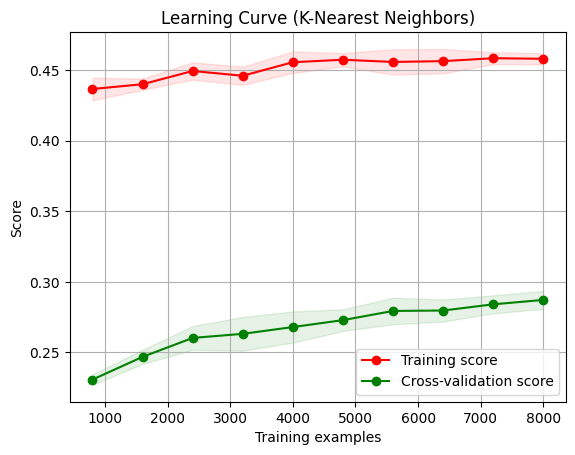

In [122]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_classifier_scaled,
    X=x_test_sample,
    y=y_test_sample,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve (K-Nearest Neighbors)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

Jak widać w klasyfikatorze KNN nie dochodzi do overfittingu na zbiorze cifar10.

Jak można było przypuszczać, klasyfikator KNN niezbyt dobrze sobie radzi na zbiorze cifar10. Można przypuszczać, że jest tak ponieważ relacje pomiędzy zdjęciami są zbyt skomplikowane aby po prostu obliczać odległość pomiędzy pikselami.

## Uczenie głębokie

### MLP perceptron

### Sieć neuronowa

### CNN – Konwolucyjna sieć neuronowa od zera

Konwolucyjne sieci neuronowe (CNN) są jednym z najpopularniejszych modeli do klasyfikacji obrazów. Składają się z warstw konwolucyjnych, warstw poolingowych oraz warstw w pełni połączonych. Warstwy konwolucyjne służą do wykrywania cech w obrazie, warstwy poolingowe do zmniejszania wymiarowości obrazu, a warstwy w pełni połączone do klasyfikacji. Ta architektura była zainspirowana budową kory wzrokowej człowieka.

![KNN1](images/knn1.png)

W naszym przypadku zbudujemy prostą sieć konwolucyjną z jedną warstwą konwolucyjną, jedną warstwą poolingową oraz jedną warstwą w pełni połączoną. Na końcu dodamy funkcję aktywacji Softmax, która zwróci prawdopodobieństwa przynależności do każdej z klas.

Następnie spróbujemy dodać więcej warstw i porównamy wyniki.

In [11]:
plt.figure()

# Iterate over each class
for i in range(10):  # Assuming 10 classes
    # Convert multiclass labels to binary labels for the selected class
    y_binary = np.array([1 if label == i else 0 for label in y_test_sample])
    
    # Predict probabilities for the selected class
    y_scores = classifier.predict_proba(x_test_sample)[:, i]  # Probability for class i
    
    # Compute ROC curve and AUC for the selected class
    fpr, tpr, thresholds = roc_curve(y_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for the selected class
    plt.plot(fpr, tpr, lw=2, label='Class {} (AUC = {:.2f})'.format(i, roc_auc))

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] Loss: 1.4222
Epoch [2/10] Loss: 1.1282
Epoch [3/10] Loss: 1.0101
Epoch [4/10] Loss: 0.9384
Epoch [5/10] Loss: 0.8902
Epoch [6/10] Loss: 0.8503
Epoch [7/10] Loss: 0.8182
Epoch [8/10] Loss: 0.7846
Epoch [9/10] Loss: 0.7632
Epoch [10/10] Loss: 0.7378
Accuracy of the simple CNN on the test images: 64.89%


Widać, że ten model ma duży potencjał - nawet w podstawowej wersji osiągnął wynik 65% dokładności. Spróbujemy teraz zbudować bardziej zaawansowany model.

Teraz staje się oczywiste czemu architektura CNN stała się przedmiotem intensywnych badań w dziedzinie widzenia komputerowego. Bez zbytnich komplikacji udało się osiągnąć wynik 75% dokładności. Okazuje się, że przy wystarczająco dużej ilości warstw i odpowiednich hiperparametrach, CNN potrafi osiągnąć wyniki porównywalne z ludźmi. Jeszce lepsze wyniki wykazuje modyfikacja CNN, czyli sieć ResNet (sieć rezydualna).

### ResNet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from accelerate import Accelerator

# Initialize the accelerator
accelerator = Accelerator()

# Define transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to match the model input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Prepare CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Function to create DataLoader
def create_dataloader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

# Load pre-trained ResNet model from timm and modify for CIFAR-10
model = timm.create_model('resnet50', pretrained=True, num_classes=10)

# Freeze initial layers
for name, param in model.named_parameters():
    if "layer4" not in name:  # Unfreeze only the last block
        param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Create data loaders
batch_size = 64
train_loader, test_loader = create_dataloader(batch_size)

# Prepare with accelerator
model, optimizer, train_loader, test_loader = accelerator.prepare(model, optimizer, train_loader, test_loader)

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        current_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            accelerator.backward(loss)
            optimizer.step()
            current_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {current_loss / len(train_loader):.4f}')
    torch.cuda.empty_cache()  # Clear GPU cache

# Function to test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training parameters
epochs = 10

# Train and test the model
train_model(model, train_loader, criterion, optimizer, epochs)
accuracy = test_model(model, test_loader)

print(f'Accuracy of fine-tuned ResNet on the test images: {accuracy * 100:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

C:\Users\jerzy\.conda\envs\ProjektZespolowy1\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jerzy\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch [1/10] Loss: 0.5842
Epoch [2/10] Loss: 0.2238
Epoch [3/10] Loss: 0.1171
Epoch [4/10] Loss: 0.0683
Epoch [5/10] Loss: 0.0511
Epoch [6/10] Loss: 0.0438
Epoch [7/10] Loss: 0.0341
Epoch [8/10] Loss: 0.0309
Epoch [9/10] Loss: 0.0284
Epoch [10/10] Loss: 0.0261
Accuracy of fine-tuned ResNet on the test images: 90.37%
